In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax.config import config
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

In [3]:
key = random.PRNGKey(12)

In [4]:
B = 300  # Number of operators (and images, B=N)
d = B  # Image dimension

In [5]:
key, subkey = random.split(key)
x0 = 13 + random.normal(subkey, (d,))

In [6]:
# Generate operators

A = np.zeros((B, d, d))
for i in range(0, B):
    # print(i)
    diag_i = np.ones(d)
    diag_i[: (i + 1)] = 0

    A[i] = np.diag(diag_i)

In [7]:
# Generate measurements
b = jnp.array([Ai @ x0 for Ai in A])

# Add noise to the measurements
key, subkey = random.split(key)

sigma = 0.01

b = b + random.normal(subkey, b.shape) * sigma

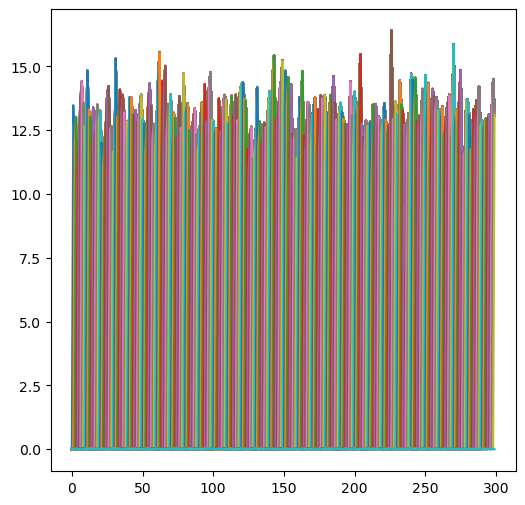

In [8]:
for i in range(b.shape[0]):
    plt.plot(b[i])

In [9]:
@jax.jit
def loss_term(x, Ai, bi, alpha):
    return 1 / 2 * jnp.sum(jnp.conj(Ai @ x - bi) * (Ai @ x - bi)) + alpha * jnp.sum(
        jnp.conj(x) * x
    )


@jax.jit
def loss_sum(x, A, b, alpha):
    return jnp.mean(jax.vmap(loss_term, in_axes=(None, 0, 0, None))(x, A, b, alpha))


@jax.jit
def grad_term(x, Ai, bi, alpha):
    return jax.grad(loss_term)(x, Ai, bi, alpha)

In [10]:
# print(loss_term(x0,A[0],b[0], 1))
# print(loss_sum(x0, A, b, 1))
# print(grad_term(x0,A[0],b[0], 1))

### "Global" parameters

In [11]:
alpha = 1e-2
b1sol = b[0, 1] / (1 + alpha * B)

key, subkey = random.split(key)
x_init = random.normal(subkey, x0.shape)

### GD with precon

In [12]:
AA = jnp.sum(jax.vmap(lambda Ai: Ai.T @ Ai, in_axes=0)(A), axis=0)

D = jnp.diag(AA) + d * alpha
u, v = jnp.linalg.eigh(AA + d * alpha * jnp.eye(d))

100.66666666666667


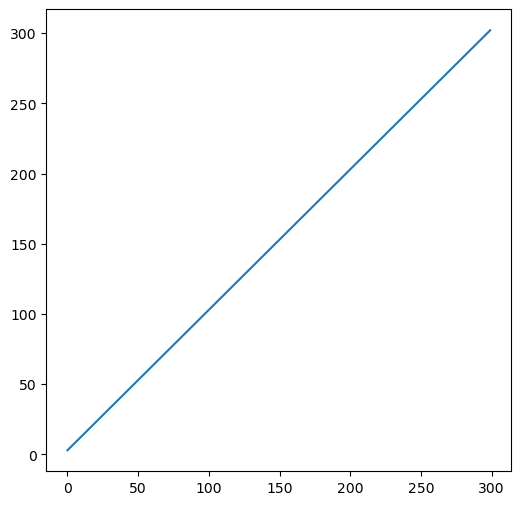

In [13]:
plt.plot(u)
print(u[-1] / u[0])

In [14]:
P = 1 / D
# P = jnp.ones(x0.shape)

In [15]:
adaptive_step_size = False

In [16]:
x_gd = x_init

x_gd_all = [x_gd]
cost_gd = [loss_sum(x_gd, A, b, alpha)]
err_x_gd = [jnp.linalg.norm(x_gd - x0)]
err_b1_gd = [b1sol - x_gd[1]]

# eta = 0.001
# eta = 100
# eta = 0.005
eta = 1
etas = [eta]
epochs = 30

for epoch in tqdm(range(epochs)):
    gradx0 = jnp.sum(
        jax.vmap(grad_term, in_axes=(None, 0, 0, None))(x_gd, A, b, alpha), axis=0
    )
    fx0 = loss_sum(x_gd, A, b, alpha)

    x1 = x_gd - eta * P * gradx0
    fx1 = loss_sum(x1, A, b, alpha)

    if adaptive_step_size:
        while fx1 > fx0 - 0.001 * eta * jnp.real(
            jnp.sum(jnp.conj(gradx0) * P * gradx0)
        ):
            eta = eta / 2
            x1 = x_gd - eta * P * gradx0
            fx1 = loss_sum(x1, A, b, alpha)

    x_gd = x1

    cost_gd.append(fx1)
    err_x_gd.append(jnp.linalg.norm(x_gd - x0))
    err_b1_gd.append(b1sol - x_gd[1])
    x_gd_all.append(x_gd)
    etas.append(eta)

cost_gd = jnp.array(cost_gd)
err_x_gd = jnp.array(err_x_gd)
err_b1_gd = jnp.array(err_b1_gd)
x_gd_all = jnp.array(x_gd_all)
etas = jnp.array(etas)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.70it/s]


In [17]:
cost_gd_noprecon = cost_gd
err_x_gd_noprecon = err_x_gd
x_gd_noprecon = x_gd

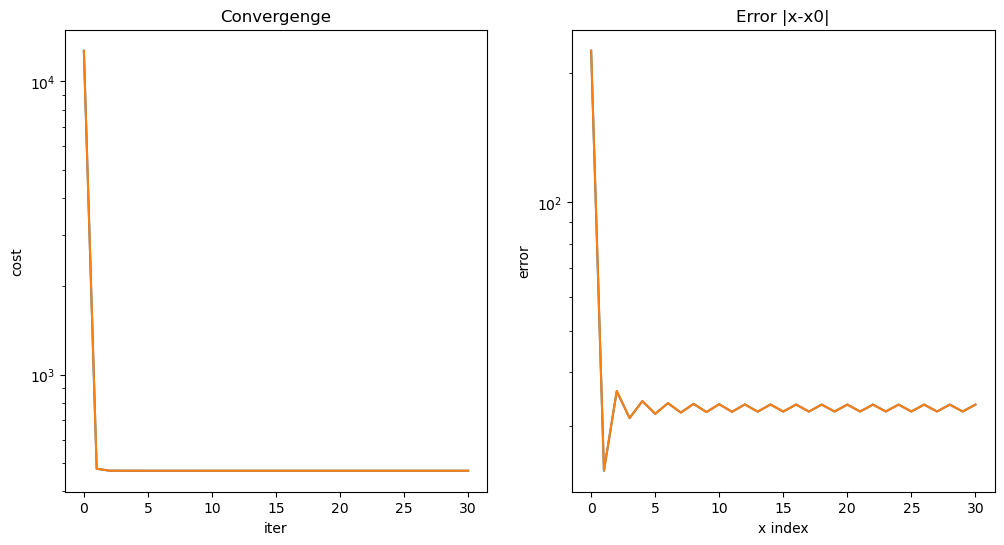

In [18]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(cost_gd_noprecon)
plt.semilogy(cost_gd)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("Convergenge")

plt.subplot(122)
plt.semilogy(err_x_gd_noprecon[:100])
plt.semilogy(err_x_gd[:100])

plt.xlabel("x index")
plt.ylabel("error")
plt.title("Error |x-x0|")

plt.rcParams["figure.figsize"] = 6, 6

### No precon, "biased"

In [19]:
D[1]

Array(4., dtype=float64)

In [20]:
AA[1, 1]

Array(1., dtype=float64)

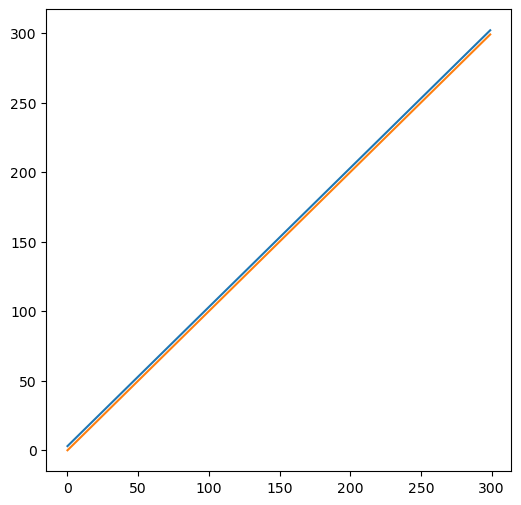

In [21]:
plt.plot(D)
plt.plot(jnp.diag(AA))

In [22]:
P = jnp.ones(x0.shape)

In [23]:
x_gd_b = D

x_gd_all_b = [x_gd]
cost_gd_b = [loss_sum(x_gd_b, A, b, alpha)]
err_x_gd_b = [jnp.linalg.norm(x_gd_b - x0)]
err_b1_gd_b = [b1sol - x_gd_b[1]]

eta = 0.005
# eta = 1
etas_b = [eta]
epochs = 30

for epoch in tqdm(range(epochs)):
    gradx0 = jnp.sum(
        jax.vmap(grad_term, in_axes=(None, 0, 0, None))(x_gd_b, A, b, alpha), axis=0
    )
    fx0 = loss_sum(x_gd_b, A, b, alpha)

    x1 = x_gd_b - eta * P * gradx0
    fx1 = loss_sum(x1, A, b, alpha)

    if adaptive_step_size:
        while fx1 > fx0 - 0.001 * eta * jnp.real(
            jnp.sum(jnp.conj(gradx0) * P * gradx0)
        ):
            eta = eta / 2
            x1 = x_gd_b - eta * P * gradx0
            fx1 = loss_sum(x1, A, b, alpha)

    x_gd_b = x1

    cost_gd_b.append(fx1)
    err_x_gd_b.append(jnp.linalg.norm(x_gd_b - x0))
    err_b1_gd_b.append(b1sol - x_gd_b[1])
    x_gd_all_b.append(x_gd_b)
    etas_b.append(eta)

cost_gd_b = jnp.array(cost_gd_b)
err_x_gd_b = jnp.array(err_x_gd_b)
err_b1_gd_b = jnp.array(err_b1_gd_b)
x_gd_all_b = jnp.array(x_gd_all_b)
etas_b = jnp.array(etas_b)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]


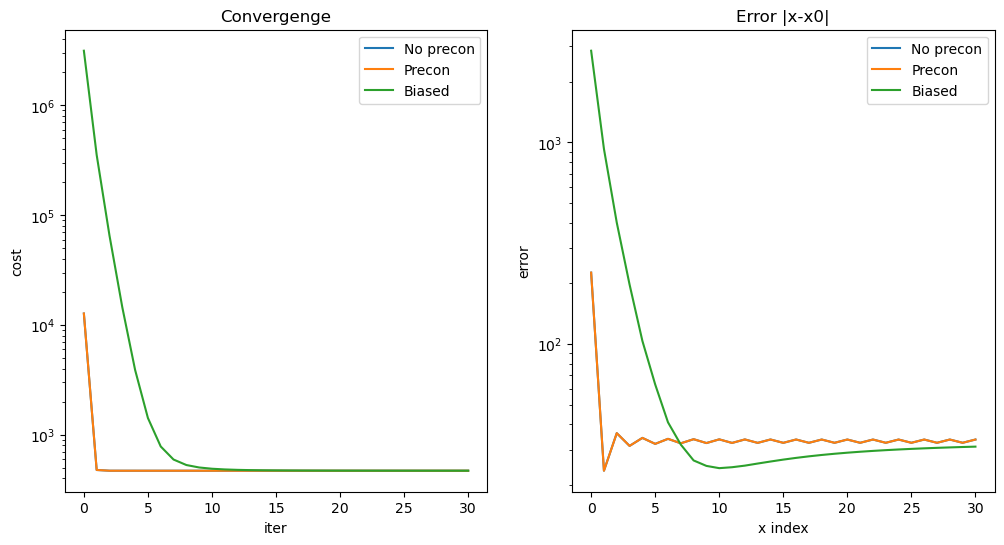

In [24]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(cost_gd_noprecon)
plt.semilogy(cost_gd)
plt.semilogy(cost_gd_b)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("Convergenge")
plt.legend(["No precon", "Precon", "Biased"])

plt.subplot(122)
plt.semilogy(err_x_gd_noprecon[:100])
plt.semilogy(err_x_gd[:100])
plt.semilogy(err_x_gd_b[:100])
plt.xlabel("x index")
plt.ylabel("error")
plt.title("Error |x-x0|")
plt.legend(["No precon", "Precon", "Biased"])

plt.rcParams["figure.figsize"] = 6, 6

In [25]:
cost_gd[-1]

Array(469.87342358, dtype=float64)

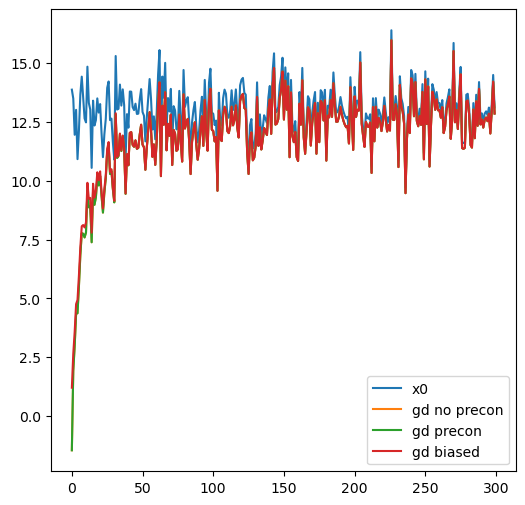

In [26]:
plt.plot(x0)
plt.plot(x_gd_noprecon)
plt.plot(x_gd)
plt.plot(x_gd_b)

plt.legend(["x0", "gd no precon", "gd precon", "gd biased"])

In [27]:
print(x0[0])
print(x_gd[0])
print(x0[0] - x_gd[0])

13.86859505517294
-1.457243839774102
15.325838894947042


In [28]:
print(b1sol)
print(x0[1])
print(x_gd[1])
print(x0[1] - x_gd[1])
print(err_b1_gd[-1])

3.37139582152871
13.491370420663639
1.9259381130404445
11.565432307623194
1.4454577084882656


In [29]:
print(x0[d - 1])
print(x_gd[d - 1])
print(x0[d - 1] - x_gd[d - 1])
print(f"sigma={sigma}")

13.113067440328582
12.854619066298287
0.2584483740302943
sigma=0.01


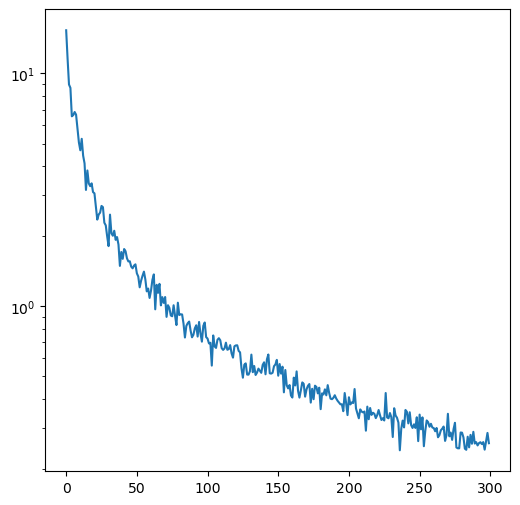

In [30]:
plt.semilogy(x0 - x_gd)

### "SGD"

### No precon

In [31]:
adaptive_step_size = False

In [32]:
P = D  # jnp.ones(x0.shape)

x_sgd = x_init

x_sgd_all_iter = [x_sgd]
x_sgd_all = [x_sgd]

cost_sgd_iter = [loss_sum(x_sgd, A, b, alpha)]
cost_sgd = [loss_sum(x_sgd, A, b, alpha)]

err_x_sgd = [jnp.linalg.norm(x_sgd - x0)]
err_x_sgd_iter = [jnp.linalg.norm(x_sgd - x0)]

err_b1_sgd = [b1sol - x_sgd[1]]
err_b1_sgd_iter = [b1sol - x_sgd[1]]

eta = 0.1

# eta = 1
etas = []
eta_max = 1
epochs = 15
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for i in tqdm(range(B)):
        if adaptive_step_size:
            eta = eta_max

        gradx0 = grad_term(x_sgd, A[i], b[i], alpha)
        fx0 = loss_term(x_sgd, A[i], b[i], alpha)

        x1 = x_sgd - eta * P * gradx0
        fx1 = loss_term(x1, A[i], b[i], alpha)

        if adaptive_step_size:
            while fx1 > fx0 - 0.9 * eta * jnp.real(
                jnp.sum(jnp.conj(gradx0) * P * gradx0)
            ):
                eta = eta / 2
                x1 = x_sgd - eta * P * gradx0
                fx1 = loss_term(x1, A[i], b[i], alpha)

        x_sgd = x1

        cost_sgd_iter.append(loss_term(x_sgd, A, b, alpha))
        err_x_sgd_iter.append(jnp.linalg.norm(x_sgd - x0))

        err_b1_sgd_iter.append(b1sol - x_sgd[1])
        x_sgd_all_iter.append(x_sgd)
        etas.append(eta)

    cost_sgd.append(loss_sum(x_sgd, A, b, alpha))
    err_x_sgd.append(jnp.linalg.norm(x_sgd - x0))
    x_sgd_all.append(x_sgd)
    err_b1_sgd.append(b1sol - x_sgd[1])

    print(eta)

cost_sgd_iter = jnp.array(cost_sgd_iter)
cost_sgd = jnp.array(cost_sgd)

err_x_sgd = jnp.array(err_x_sgd)

err_b1_sgd_iter = jnp.array(err_b1_sgd_iter)
err_b1_sgd = jnp.array(err_b1_sgd)

etas = jnp.array(etas)

x_sgd_all = jnp.array(x_sgd_all)

Epoch 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 103.07it/s]


0.1
Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 104.24it/s]


0.1
Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 104.80it/s]


0.1
Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.12it/s]


0.1
Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 104.87it/s]


0.1
Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.31it/s]


0.1
Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.53it/s]


0.1
Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.41it/s]


0.1
Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.21it/s]


0.1
Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.44it/s]


0.1
Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.18it/s]


0.1
Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 104.57it/s]


0.1
Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.03it/s]


0.1
Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 104.96it/s]


0.1
Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.47it/s]


0.1


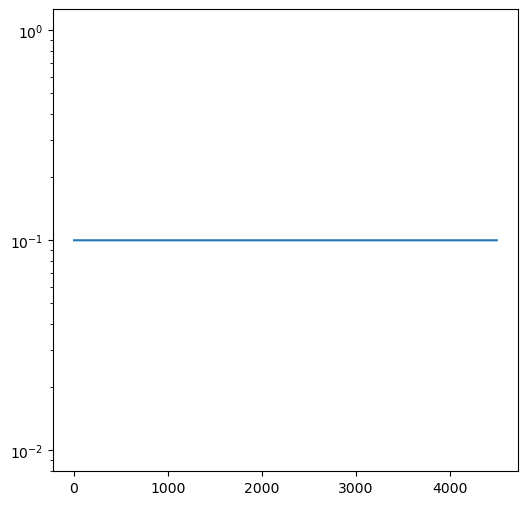

In [33]:
plt.semilogy(etas)

### Precon

In [34]:
adaptive_step_size = True

In [35]:
P = 1 / D
x_sgd_p = x_init

x_sgd_p_all_iter = [x_sgd_p]
x_sgd_p_all = [x_sgd_p]

cost_sgd_p_iter = [loss_sum(x_sgd_p, A, b, alpha)]
cost_sgd_p = [loss_sum(x_sgd_p, A, b, alpha)]

err_x_sgd_p = [jnp.linalg.norm(x_sgd_p - x0)]
err_x_sgd_p_iter = [jnp.linalg.norm(x_sgd_p - x0)]

err_b1_sgd_p = [b1sol - x_sgd_p[1]]
err_b1_sgd_p_iter = [b1sol - x_sgd_p[1]]

# eta = 0.1

# eta = 100
etas = []

eta_max = 1
eta_epoch = eta_max * jnp.ones((B,))

grads = []
gradnorms = []
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    for i in tqdm(range(B)):
        if adaptive_step_size:
            eta = eta_max
        else:
            eta = eta_epoch[i]

        gradx0 = grad_term(x_sgd_p, A[i], b[i], alpha)
        fx0 = loss_term(x_sgd_p, A[i], b[i], alpha)

        x1 = x_sgd_p - eta * P * gradx0
        fx1 = loss_term(x1, A[i], b[i], alpha)

        if adaptive_step_size:
            while fx1 > fx0 - 0.9 * eta * jnp.real(
                jnp.sum(jnp.conj(gradx0) * P * gradx0)
            ):
                eta = eta / 2
                x1 = x_sgd_p - eta * P * gradx0
                fx1 = loss_term(x1, A[i], b[i], alpha)

        x_sgd_p = x1

        cost_sgd_p_iter.append(loss_term(x_sgd_p, A, b, alpha))
        err_x_sgd_p_iter.append(jnp.linalg.norm(x_sgd_p - x0))

        err_b1_sgd_p_iter.append(b1sol - x_sgd_p[1])
        x_sgd_p_all_iter.append(x_sgd_p)

        # Actually save all the etas for each x entry
        etas.append(eta)
        grads.append(gradx0)
        gradnorms.append(jnp.real(jnp.sum(jnp.conj(gradx0) * P * gradx0)))

        eta_epoch = eta_epoch.at[i].set(eta)

    cost_sgd_p.append(loss_sum(x_sgd_p, A, b, alpha))
    err_x_sgd_p.append(jnp.linalg.norm(x_sgd_p - x0))
    x_sgd_p_all.append(x_sgd_p)
    err_b1_sgd_p.append(b1sol - x_sgd_p[1])

cost_sgd_p_iter = jnp.array(cost_sgd_p_iter)
cost_sgd_p = jnp.array(cost_sgd_p)

err_x_sgd_p = jnp.array(err_x_sgd_p)

err_b1_sgd_p_iter = jnp.array(err_b1_sgd_p_iter)
err_b1_sgd_p = jnp.array(err_b1_sgd_p)

etas = jnp.array(etas)
grads = jnp.array(grads)
gradnorms = jnp.array(gradnorms)

x_sgd_p_all = jnp.array(x_sgd_p_all)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 94.67it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.39it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.13it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.08it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.58it/s]


Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 93.51it/s]


Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.55it/s]


Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.20it/s]


Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.53it/s]


Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.41it/s]


Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.53it/s]


Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 94.87it/s]


Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 94.36it/s]


Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 93.66it/s]


Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 94.23it/s]


Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.12it/s]


Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.08it/s]


Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.16it/s]


Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 97.82it/s]


Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 97.94it/s]


Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 97.92it/s]


Epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.11it/s]


Epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.18it/s]


Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 97.97it/s]


Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.13it/s]


Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 96.97it/s]


Epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 96.81it/s]


Epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.42it/s]


Epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.07it/s]


Epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.39it/s]


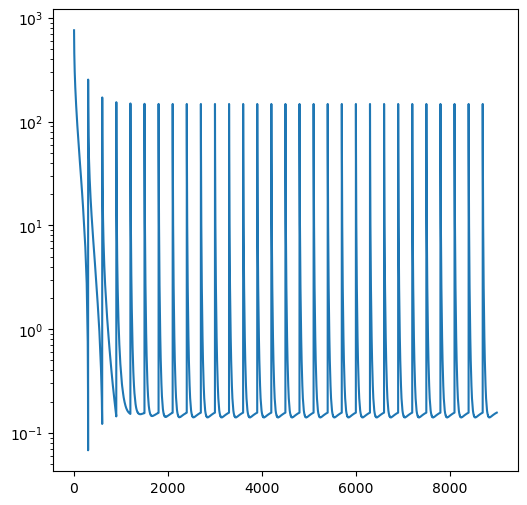

In [36]:
plt.semilogy(gradnorms)

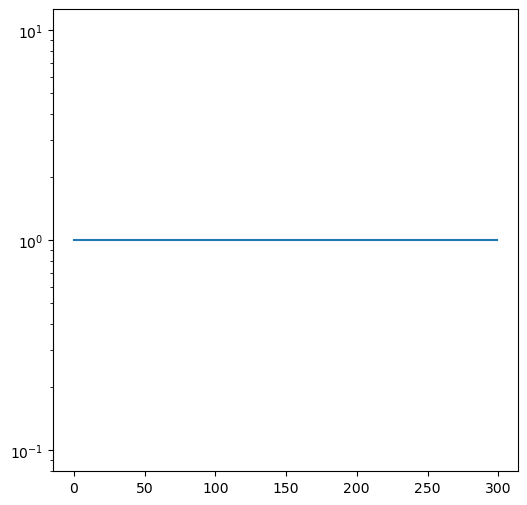

In [37]:
plt.semilogy(eta_epoch)

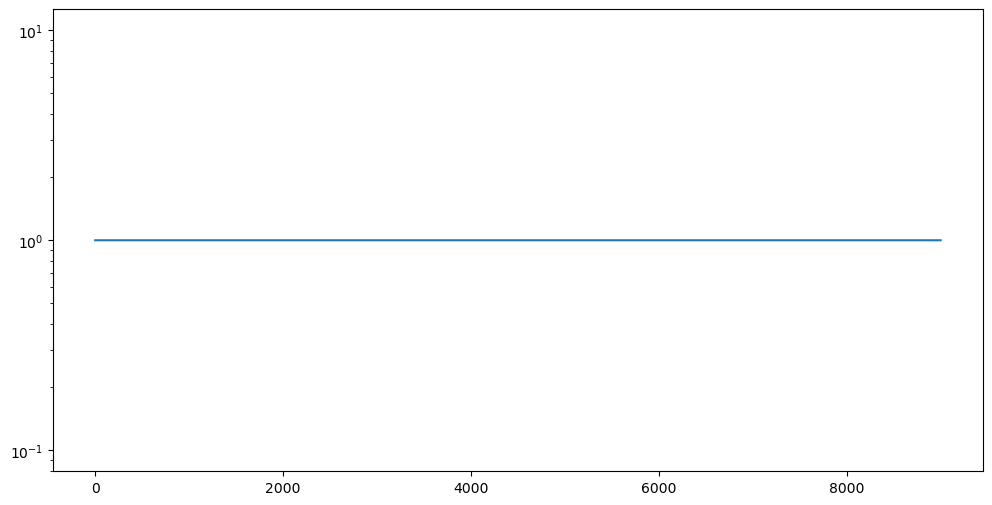

In [38]:
plt.rcParams["figure.figsize"] = 12, 6
plt.semilogy(etas)
plt.rcParams["figure.figsize"] = 6, 6

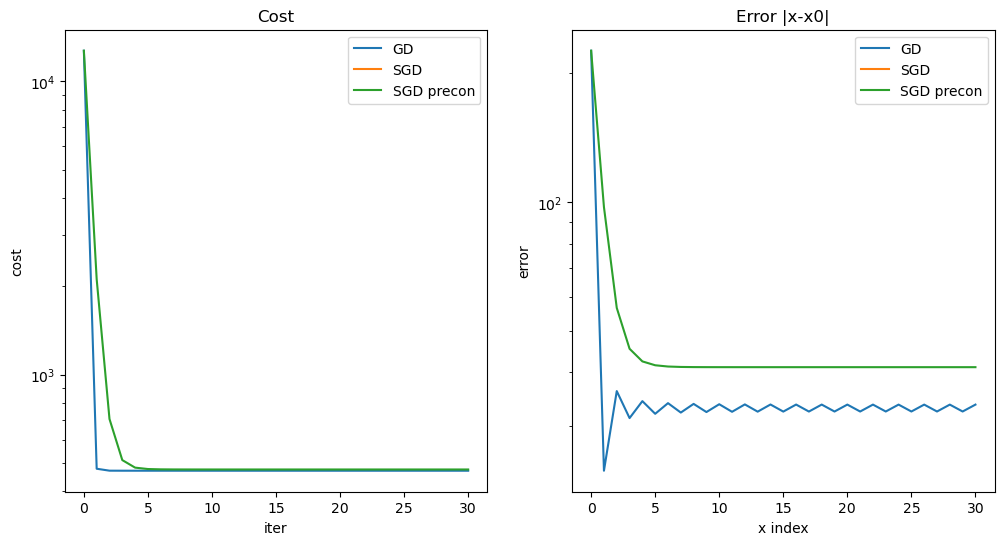

In [39]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(cost_gd)
plt.semilogy(cost_sgd)
plt.semilogy(cost_sgd_p)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("Cost")
plt.legend(["GD", "SGD", "SGD precon"])

plt.subplot(122)
plt.semilogy(err_x_gd)
plt.semilogy(err_x_sgd)
plt.semilogy(err_x_sgd_p)

plt.xlabel("x index")
plt.ylabel("error")
plt.title("Error |x-x0|")
plt.legend(["GD", "SGD", "SGD precon"])

plt.rcParams["figure.figsize"] = 6, 6

In [40]:
print(x0[0])
print(x_sgd[0])
print(x0[0] - x_sgd[0])

13.86859505517294
nan
nan


In [41]:
print(b1sol)
print(x0[1])
print(x_sgd[1])
print(x0[1] - x_sgd[1])
print(err_b1_sgd[-1])

3.37139582152871
13.491370420663639
nan
nan
nan


In [42]:
print(x0[d - 1])
print(x_sgd[d - 1])
print(x0[d - 1] - x_sgd[d - 1])
print(f"sigma={sigma}")

13.113067440328582
nan
nan
sigma=0.01


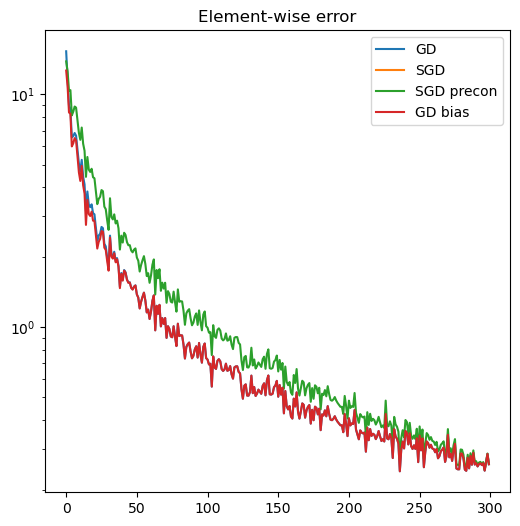

In [43]:
plt.semilogy(jnp.abs(x0 - x_gd))
plt.semilogy(jnp.abs(x0 - x_sgd))
plt.semilogy(jnp.abs(x0 - x_sgd_p))
plt.semilogy(jnp.abs(x0 - x_gd_b))


plt.title("Element-wise error")
plt.legend(["GD", "SGD", "SGD precon", "GD bias"])

(31, 300)


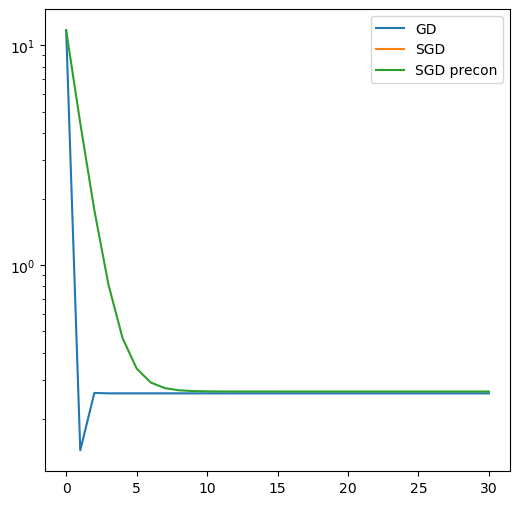

In [44]:
print(x_sgd_p_all.shape)

idx = 290
plt.semilogy(jnp.abs(x_gd_all[:, idx] - x0[idx]))
plt.semilogy(jnp.abs(x_sgd_all[:, idx] - x0[idx]))
plt.semilogy(jnp.abs(x_sgd_p_all[:, idx] - x0[idx]))

plt.legend(["GD", "SGD", "SGD precon"])

In [45]:
x_gd_all.shape

(31, 300)

In [46]:
idx = 50
print(sigma)
print(alpha)
print(x0[idx])
print(x_gd_all[9, idx] - x_sgd_p_all[9, idx])

0.01
0.01
12.918022291069274
0.6090719487546217


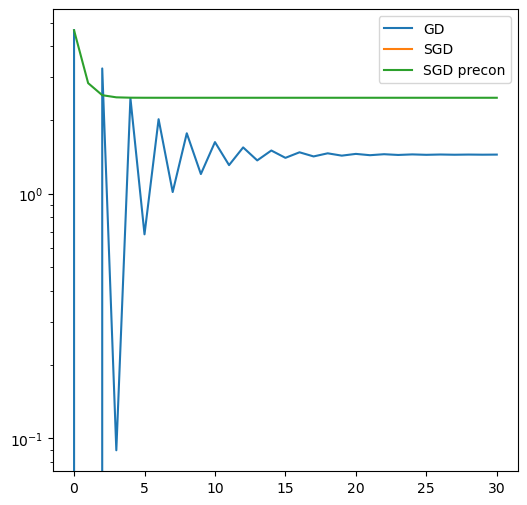

In [47]:
plt.semilogy(err_b1_gd)
plt.semilogy(err_b1_sgd)
plt.semilogy(err_b1_sgd_p)
plt.legend(["GD", "SGD", "SGD precon"])

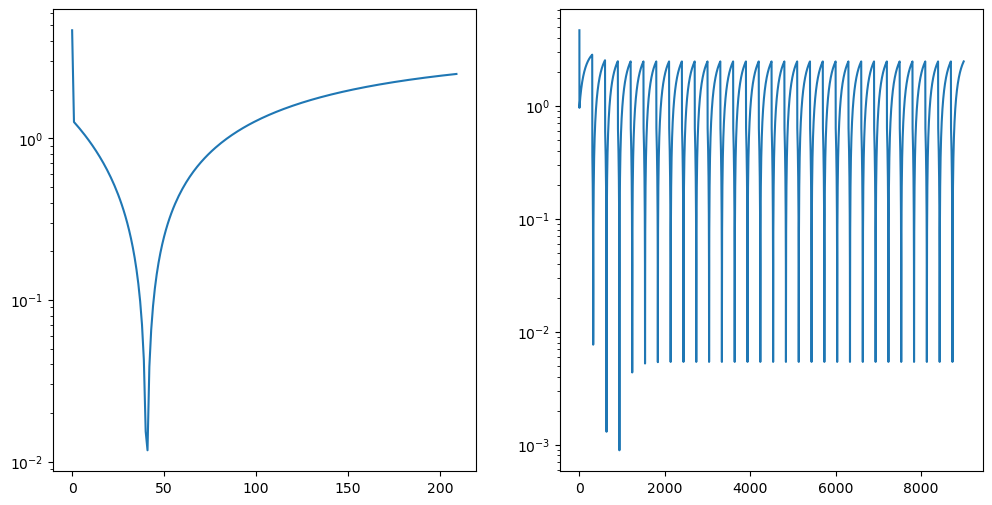

In [48]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(jnp.abs(err_b1_sgd_iter))

plt.subplot(122)
plt.semilogy(jnp.abs(err_b1_sgd_p_iter))

plt.rcParams["figure.figsize"] = 6, 6